### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from CartPole import CartPole
# from CartPole_GPS import CartPole_GPS

from ilqr.dynamics import constrain
from copy import deepcopy

from EstimateDynamics import local_estimate
from GMM import Estimated_Dynamics_Prior

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


### Formulate the iLQR problem

In [2]:
'''
1 - dt = time step
2 - N = Number of control points in the trajectory
3 - x0 = Initial state
4 - x_goal = Final state
5 - Q = State cost
6 - R = Control cost
7 - Q_terminal = Cost at the final step
8 - x_dynamics array stores the information regarding system. 
    x_dynamics[0] = m = mass of the pendulum bob 
    x_dynamics[1] = M = mass of the cart 
    x_dynamics[2] = L = length of the massless rod 
    x_dynamics[3] = g = gravity 
    x_dynamics[4] = d = damping in the system
'''
dt = 0.01
N = 2000  # Number of time steps in trajectory.
x_dynamics = np.array([1, 5, 2, 9.80665, 0.5]) # m=1, M=5, L=2, g=9.80665, d=1
x0 = np.array([-2.0, 0.0, 0.14, 0.0])  # Initial state
x_goal = np.array([3.0, 0.0, 0.0, 0.0])
# Instantenous state cost.
Q = np.eye(5)
Q[2, 2] = 1
Q[3, 3] = 1
# Q[4, 4] = 100
# Terminal state cost.
Q_terminal = np.eye(5)
Q_terminal[2, 2] = 100
Q_terminal[3, 3] = 100
# Instantaneous control cost.
R = np.array([[1.0]])

### iLQR on Cart Pole

In [3]:
cartpole_prob = CartPole(dt, N, x_dynamics, x0, x_goal, Q, R, Q_terminal)
xs, us, K, k = cartpole_prob.run_IterLinQuadReg()

iteration 0 accepted 48918.97136341531 [ 5.12581267 -0.33487694 -0.73803684  2.37771454]
iteration 1 accepted 48888.88432326755 [ 5.08835356 -0.35926138 -0.72548777  2.37284837]
iteration 2 accepted 48864.61480042413 [ 5.1435757  -0.36037315 -0.72215214  2.37770659]
iteration 3 failed 48864.61480042419 [ 5.1435757  -0.36037315 -0.72215214  2.37770659]
iteration 4 failed 48864.61480042419 [ 5.1435757  -0.36037315 -0.72215214  2.37770659]
iteration 5 accepted 39053.27544063534 [ 0.78659098 -0.0075366  -1.95068247  3.33825385]
iteration 6 accepted 39052.4423088635 [ 0.77814859 -0.01723536 -1.94241867  3.33089197]
iteration 7 accepted 28538.872750315124 [ 3.28236941 -0.62134707 -0.94804648  2.18122277]
iteration 8 accepted 28529.885067941592 [ 3.30189163 -0.63191569 -0.90192741  2.12125741]
iteration 9 accepted 27752.609812358703 [ 2.87549816 -0.77846753 -0.51444046  1.57752106]
iteration 10 accepted 27427.371169866194 [ 2.09666716 -0.59527483  0.29973071  1.23707477]
iteration 11 accepted

/usr/local/lib/python3.6/dist-packages/ilqr-0.1.0-py3.6.egg/ilqr/controller.py:168: UserWarning: exceeded max regularization term


In [4]:
# State matrix split into individual states. For plotting and analysing purposes.
t = np.arange(N + 1) * dt
x = xs[:, 0] # Position
x_dot = xs[:, 1] # Velocity
theta = np.unwrap(cartpole_prob.deaugment_state(xs)[:, 2])  # Theta, makes for smoother plots.
theta_dot = xs[:, 3] # Angular velocity

### Simulate the real system and generate the data
Cost matrices, initial position and goal position will remain same as the above problem. As it indicates one policy. But still the initial positions and goal positions must be passed explicitly to the function. But you don't need to pass cost matrices (assume penalty on the system is same), this is just used to use to calculate the cost of the trajectory. Correct control action must be passed. Parameter gamma indicates how much of original data you want to keep

Variance of the Gaussian noise will be taken as input from a Unif(0, var_range) uniform distribution. Inputs: x_initial, x_goal, u, n_rollouts, pattern='Normal', pattern_rand=False, var_range=10, gamma=0.2, percent=20

Pattern controls how the control sequence will be modified after applying white Guassian noise (zero mean).
- Normal: based on the correction/mixing parameter gamma generate control (gamma controls how much noise we want).
- MissingValue: based on the given percentage, set those many values to zero (it is implicitly it uses "Normal" generated control is used). 
- Shuffle: shuffles the entire "Normal" generated control sequence.
- TimeDelay: takes the "Normal" generated control and shifts it by 1 index i.e. one unit time delay.
- Extreme: sets gamma as zeros and generates control based on only noise.

If 'pattern_rand' is 'True' then we don't need to send the explicitly, it will chose one randomly for every rollout (default is 'False'). If you want to chose specific pattern then send it explicitly. 

In [5]:
x_rollout, u_rollout, local_policy, cost = cartpole_prob.gen_rollouts(x0, x_goal, us, n_rollouts=10, pattern_rand=True, var_range=10, gamma=0.2, percent=20)

### Local system dynamics/model estimate
loca_estimate: function takes the states (arranged in a special format, [x(t), u(t), x(t+1)]), no. of gaussian mixtures and no.of states.

In [6]:
model = Estimated_Dynamics_Prior(init_sequential=False, eigreg=False, warmstart=True, 
                 min_samples_per_cluster=20, max_clusters=50, max_samples=20, strength=1.0)
model.update_prior(x_rollout, u_rollout)
A, B, C = model.fit(x_rollout, u_rollout)

In [7]:
print(A.shape)
print(B.shape)
print(C.shape)

(2001, 5, 6)
(2001, 5)
(2001, 5, 5)


In [8]:
u_rollout.shape

(10, 2001, 1)

### iLQR on estimated model
Here system dynamics is specified in a special way. We give the A, B, C matrices as input. These matrices comes from GMM and GPS theory. They are the mean/expected trajectory followed by the states which is represented by the mean & covariance (A, B, C) matrices of a Gaussian. Remaining all properties of the iLQR problem remains the same (cost, initial & goal state, time steps). 

In [9]:
x_traj,u_traj = cartpole_prob.run_IterLinQuadReg_matrix(A, B, C)

iteration 0 accepted 1058516.078035197 [12.33270979 -4.20832417  3.00151915 30.21325888]
iteration 1 accepted 1043687.1264950135 [12.41181649 -4.1489411  -0.16639959 29.93688112]
iteration 2 accepted 1032546.9683574325 [12.29263146 -4.13751007 -2.89601133 29.96169859]
iteration 3 accepted 1022112.2145055033 [12.35568143 -4.20816886  0.83399165 29.63805516]
iteration 4 accepted 1012896.7079382048 [12.53030444 -3.94727217 -1.83588076 29.73216545]
iteration 5 accepted 1004621.2693599659 [12.26726861 -4.15497356  2.35622559 29.57032181]
iteration 6 accepted 996045.0015898119 [12.58873182 -3.95537318 -0.20681868 29.36616286]
iteration 7 accepted 988727.3587337902 [12.48222069 -3.88887386 -2.38273194 29.46761107]
iteration 8 accepted 981340.8248406937 [12.35318415 -4.06668463  1.83644196 29.17565519]
iteration 9 accepted 973633.7908605979 [12.69967713 -3.78367756 -0.68418698 29.06424552]
iteration 10 accepted 966951.3737955018 [12.50203549 -3.81050533 -2.65158182 29.11873129]
iteration 11 ac

iteration 91 accepted 45108.43869996027 [3.99021929 3.43407754 3.01717095 5.13308418]
iteration 92 accepted 44088.21152848433 [2.07777431 1.75318769 1.62731187 2.86866786]
iteration 93 accepted 43615.43521089221 [1.37891393 0.72983816 0.5580672  0.77514356]
iteration 94 accepted 43525.085237726715 [ 1.39898777  0.48413142  0.02580028 -0.18243221]
iteration 95 accepted 43517.478124154964 [ 1.46117888  0.45674136 -0.13612152 -0.44553646]
iteration 96 accepted 43516.98901816494 [ 1.48307402  0.45426302 -0.17771158 -0.51055062]
iteration 97 accepted 43516.957733944 [ 1.489106    0.45397149 -0.18826283 -0.5268741 ]
iteration 98 accepted 43516.955719941965 [ 1.49066936  0.45391956 -0.19094182 -0.53100762]
iteration 99 accepted 43516.95559001886 [ 1.49106857  0.45390779 -0.19162236 -0.53205695]


In [10]:
from scipy.stats.mstats import gmean
# a = gmean(A,axis=0)
a = np.sum(B, axis=0,keepdims=True)/B.shape[0]
a.shape

(1, 5)

### Plot

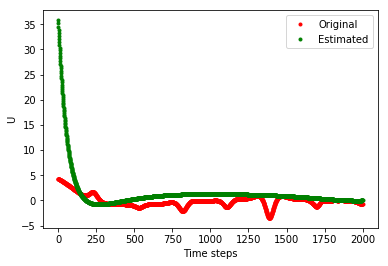

In [12]:
# Control sequence
plt.plot(np.arange(us.shape[0]), us, 'r.', label='Original')
# plt.plot(np.arange(us.shape[0]), u_rollout[0:N], 'b.', label='Corrupted')
plt.plot(np.arange(us.shape[0]), u_traj, 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('U')
plt.legend()
plt.show()

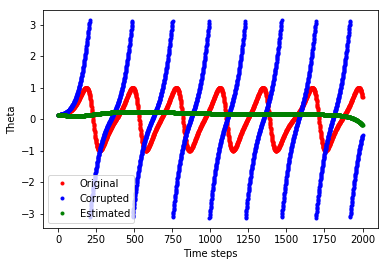

In [13]:
plt.plot(np.arange(xs.shape[0]), xs[:, 2], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout)[0:N+1, 2], 'b.', label='Corrupted')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 2], 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('Theta')
plt.legend()
plt.show()

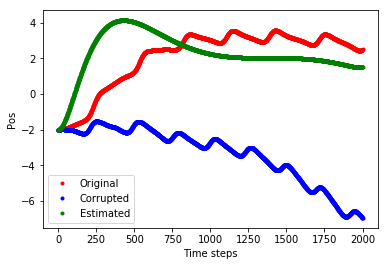

In [14]:
plt.plot(np.arange(xs.shape[0]), xs[:, 0], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout)[0:N+1, 0], 'b.', label='Corrupted')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 0], 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('Pos')
plt.legend()
plt.show()

### GPS 

In [ ]:
dt = 0.005
N = 500  # Number of time steps in trajectory.
x_dynamics = np.array([1, 5, 2, 9.80665, 1]) # m=1, M=5, L=2, g=9.80665, d=1
# Instantenous state cost.
Q = np.eye(5)
Q[1,1] = 10
Q[2, 2] = 1
Q[3, 3] = 10
Q[4, 4] = 1
# Terminal state cost.
Q_terminal = 100 * np.eye(5)
# Instantaneous control cost.
R = np.array([[1.0]])

In [ ]:
x_train = []
u_train = []
for i in range(10):
    print('iteration is ',i)
    x0 = np.array([2, 0, 0.001*i , 0])  # Initial state
    x_goal = np.array([2, 0.0, 0.0, 0.0])
    cartpole_prob = CartPole(dt, N, x_dynamics, x0, x_goal, Q, R, Q_terminal)
    xs, us = cartpole_prob.run_IterLinQuadReg()
    t = np.arange(N + 1) * dt
    x = xs[:, 0] # Position
    x_dot = xs[:, 1] # Velocity
    theta = np.unwrap(cartpole_prob.deaugment_state(xs)[:, 2])  # Theta, makes for smoother plots.
    theta_dot = xs[:, 3] # Angular velocity
    x_rollout, u_rollout, local_policy, x_gmm, cost = cartpole_prob.gen_rollouts(x0, x_goal, us, 
                                     n_rollouts=20, pattern_rand=False, var_range=10, gamma=0.8, percent=20)
    model = local_estimate(x_gmm, components=5, NoOfstates=5)
    A, B, C = model.estimate(N=N)
    x_traj,u_traj = cartpole_prob.run_IterLinQuadReg_matrix(A, B, C)
    x_train.append(x_traj)
    u_train.append(u_traj)

In [ ]:
x_train1 = x_train[0][:-1]
u_train1 = u_train[0]
for i in range(1,9):
    x_train1 = np.vstack((x_train1,x_train[i][:-1]))
    u_train1 = np.vstack((u_train1,u_train[i]))

In [ ]:
u_gr = constrain(u_train1,-0.9,0.9)

In [ ]:
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(x_train1, u_gr)

In [ ]:
gpr.score(x_train1,u_gr)

In [ ]:
u_pre = gpr.predict(xs)

In [ ]:
plt.plot(np.arange(us.shape[0]), constrain(us, -0.9, 0.9), 'r.', label='Original')
plt.plot(np.arange(us.shape[0]), constrain(u_pre[0:N],-0.9,0.9), 'b.', label='Global')
plt.plot(np.arange(us.shape[0]), constrain(u_traj, -0.9, 0.9), 'g.', label='Local')
plt.xlabel('Time steps')
plt.ylabel('U')
plt.legend()
plt.savefig('control.pdf')
plt.show()

In [ ]:
x_rollout00, u_rollout00, local_policy00, x_gmm00, cost00 = cartpole_prob.gen_rollouts(x0, x_goal, u_pre[:-1], n_rollouts=10, var_range=0, gamma=1, percent=0)

In [ ]:
plt.plot(np.arange(xs.shape[0]), xs[:, 0], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout00)[0:N+1, 0], 'b.', label='Global')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 0], 'g.', label='Local')
plt.xlabel('Time steps')
plt.ylabel('Pos')
plt.legend()
plt.savefig('position.pdf')
plt.show()

In [ ]:
plt.plot(np.arange(xs.shape[0]), xs[:, 2], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout00)[0:N+1, 2], 'b.', label='Global')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 2], 'g.', label='Local')
plt.xlabel('Time steps')
plt.ylabel('Theta')
plt.legend()
plt.savefig('theta.pdf')
plt.show()

In [ ]:
# plt.subplot(3,1,1)
# plt.plot(np.arange(us.shape[0]), constrain(us, -0.9, 0.9), 'r.', label='Original')
# plt.plot(np.arange(us.shape[0]), constrain(u_pre[0:N],-0.9,0.9), 'b.', label='GPS')
# plt.plot(np.arange(us.shape[0]), constrain(u_traj, -0.9, 0.9), 'g.', label='Estimated')
# plt.xlabel('Time steps')
# plt.ylabel('U')
# plt.legend()
# plt.title('Control action vs time')


plt.subplot(2,1,1)
plt.plot(np.arange(xs.shape[0]), xs[:, 0], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout00)[0:N+1, 0], 'b.', label='Corrupted')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 0], 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.title('position vs time')
plt.ylabel('Pos')



plt.subplot(2,1,2)
plt.plot(np.arange(xs.shape[0]), xs[:, 2], 'r.', label='Original' , lw=2)
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout00)[0:N+1, 2], 'b.', label='Corrupted' , lw=2)
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 2], 'g.', label='Estimated', lw=2)
plt.xlabel('Time steps')
plt.title('theta vs time')
plt.ylabel('Theta')

plt.subplots_adjust(hspace=1.5)
plt.savefig('total.pdf')
plt.show()

In [ ]:
np.isclose([1,0.2], [1,0.1],atol=0.1).all()

In [16]:
from Simulator import Mujoco_sim
Model = "mujoco/cartpole.xml"
cart_pole_simulator = Mujoco_sim(Model,True)
cart_pole_simulator.load(xs,us,k,K,x0,initial=False)
cart_pole_simulator.runSimulation()

model added to the simulator
Creating window glfw
